In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

import torch
torch.set_printoptions(edgeitems=5, linewidth=120)

# создаем данные

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

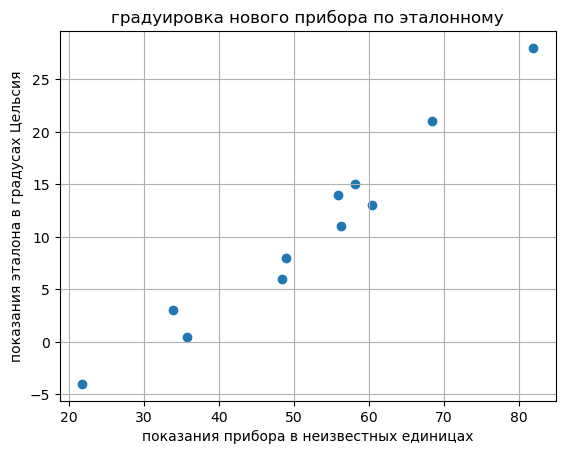

In [3]:
plt.scatter(t_u,t_c)
plt.title('градуировка нового прибора по эталонному')
plt.xlabel('показания прибора в неизвестных единицах')
plt.ylabel('показания эталона в градусах Цельсия')
plt.grid()
plt.show()

# как это делается на `pyTorch`

## model = linear

In [4]:
def model(t_u, w, b):
    return w * t_u + b

## Loss-function = MSE

In [5]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

## starting from assumption U=C

In [6]:
w = torch.ones(())
w

tensor(1.)

In [7]:
b = torch.zeros(())
b

tensor(0.)

### проверим модель

In [8]:
t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000, 48.4000, 60.4000, 68.4000])

In [9]:
t_u

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000, 48.4000, 60.4000, 68.4000])

### проверим функцию потерь

In [10]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

# NB!: Broadcasting 
очень популярная возможность NumPy, принятая на вооружение в PyTorch, снимает требование полного совпадения размерности по всем измерениям тензоров-операндов для большинства (скалярных) бинарных операций. Применение бинарных операций к элементам тензоров производится на основе следующих правил:
1) Для каждого измерения, применяя с конца списка индексов тензора:
   * если размерность одного из операндов в этом измерении равна 1 (операнд - скаляр по данному измерению), PyTorch производит операцию с единственным элементом по этому измерению для каждого из элементов в другом тензоре по этому же измерению
   * Если обе размерности превышают 1, они должны совпадать (*иначе выдается ошибка несоответствия измерений тензоров-операндов*) и применяется обычный способ попарного применения операции.
2) Если длина списка индексов у одного из тензоров больше, чем у другого, для каждого элемента по "лишним" измерениям слава используется весь второй (более короткий по списку индексов) тензор - как инстанциируемое значение, что совпало бы с применением правила №1 выше, после добавления новых измерений скалярной размерности слева к тензору с более коротким списком индексов.

**то есть, при broadcasting помимо очевидного поэлементного действия над векторами в данном измерении (обработка измерений проходит справа налево по списку индексов каждого операнда), разрешается рассматривать и скалярную размерность (1) вместо вектора общей размерности для одного из операндов в обрабатываемом измерении.  При этом, если список индексов у одного операнда заканчивается раньше, то ему докидывается слева отсутствующее число индексов-измерений скалярной размерности (1)**

## ниже иллюстрация данного принципа в действии

In [11]:
x = torch.ones(())
y = torch.ones(3,1) * 2
z = torch.ones(1,3) * 3
a = torch.ones(2, 1, 1) * 4

print()
print(f"shapes: x: {x.shape}      y: {y.shape}")
print(f"        z: {z.shape}  a: {a.shape}")
print('-'*30)
print("x * y:".rjust(10), (x * y).shape)
print("y * z:".rjust(10), (y * z).shape)
print("y * z * a:".rjust(10), (y * z * a).shape)
print()


shapes: x: torch.Size([])      y: torch.Size([3, 1])
        z: torch.Size([1, 3])  a: torch.Size([2, 1, 1])
------------------------------
    x * y: torch.Size([3, 1])
    y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])



In [12]:
y

tensor([[2.],
        [2.],
        [2.]])

In [13]:
z

tensor([[3., 3., 3.]])

In [14]:
a

tensor([[[4.]],

        [[4.]]])

In [15]:
y * z

tensor([[6., 6., 6.],
        [6., 6., 6.],
        [6., 6., 6.]])

In [16]:
y * z * a

tensor([[[24., 24., 24.],
         [24., 24., 24.],
         [24., 24., 24.]],

        [[24., 24., 24.],
         [24., 24., 24.],
         [24., 24., 24.]]])

# `GD` - ГРАДИЕНТНЫЙ СПУСК

## сперва градиент оценивается инкрементально

In [17]:
delta = 0.01                    # weights step for gradient components estimation

learning_rate = 0.001           # weights step opposite to gradient estimation vector

### оценка компоненты градиента вдоль веса slope (w)

In [18]:
loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) - 
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

### оценка компоненты градиента вдоль веса intercept (b)

In [19]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) - 
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

### грубое обновление весов по алгоритму GD

In [20]:
print(w, '-->', w - learning_rate * loss_rate_of_change_w)
print(b, '-->', b - learning_rate * loss_rate_of_change_b)

tensor(1.) --> tensor(-3.5173)
tensor(0.) --> tensor(-0.0826)


**видно, что мы сильно перелетели через оптимальное значение - нужно более точно оценивать градиент**

## для MSE в SLR можно и аналитически посчитать градиент
**здесь $p$ - число параметров-весов, а $w_0\equiv b$**

$$
dL_{oss} = \sum_{i=0}^p \frac{\partial L_{oss}}{\partial w_i} dw_i \equiv (\nabla_w L_{oss})^T \cdot dw
$$

$$
\nabla_w L_{oss} \equiv \left( \frac{\partial L_{oss}}{\partial w_i} \right)^T
$$

**последняя формула - определение вектора градиента (все вектора - столбцы, а выражение $\partial L_{oss}/\partial w_i$ - строка, при транспонировании которой получаем вектор градиента - чтобы работала первая формула скалярного произведения градиента на вектор дифференциала $dw$)**

### поскольку функция потерь определяется в пространстве вектора ответов $\,\hat y = t_p = t_u^T \cdot w+b\,$, то градиент потерь по весам связан с градиентом потерь по ответам через матрицу Якоби ответов и весов:

$$
\frac{\partial L_{oss}}{\partial w_i} = \frac{\partial L_{oss}}{\partial \hat y_j} \,\cdot\, \frac{\partial\hat y_j}{\partial w_i}  
$$

$$
\nabla_w L_{oss} = \left(\frac{\partial L_{oss}}{\partial \hat y_j} \,\cdot\, \frac{\partial\hat y_j}{\partial w_i}\right)^T =
\left(\frac{\partial\hat y_j}{\partial w_i}\right)^T \,\cdot\, \nabla_{\hat y} L_{oss} \,\,\,\equiv\,\,\, 
J^T \,\cdot\, \nabla_{\hat y} L_{oss}
$$

$$
d\hat y \equiv J \cdot dw \,\,\,\Rightarrow\,\,\, J_{ji} \equiv \left(\frac{\partial\hat y_j}{\partial w_i}\right)
$$

**здесь в $J_{ji}$ первый индекс строка в пространстве ответов, а второй столбец в пространстве весов, поэтому при домножении слева в формуле градиентов матрицу Якоби нужно транспонировать**

### если функция потерь выбрана как MSE, то вот это верно для любой модели $\,\hat y\,$:

$$
L_{oss} = \frac{1}{n}\, (\hat y - y)^T\cdot(\hat y - y) \,\,\,\Rightarrow\,\,\,  \frac{\partial L_{oss}}{\partial \hat y_j} = 
\frac{2}{n}\, (\hat y - y)^T \,\,\,\Rightarrow\,\,\,  
\nabla_{\hat y} L_{oss} = \frac{2}{n}\, (\hat y - y)
$$

$$
\nabla_w L_{oss} = J^T \,\cdot\, \nabla_{\hat y} L_{oss} = \frac{2}{n}\, J^T \,\cdot\, (\hat y - y)
$$

### для линейной модели $J \equiv X$ можно было бы еще преобразовать в общем виде:

$$
\nabla_w L_{oss} = X^T \,\cdot\, \nabla_{\hat y} L_{oss} = \frac{2}{n}\, X^T \,\cdot\, (\hat y - y)
$$
где
$$
\hat y = X\cdot w
$$

### в нашем случае:

$$
\hat y = \left( \begin{array}{c} 
                t_p{}_1 \\
                t_p{}_2 \\
                    ... \\
                t_p{}_n \\
                \end{array} \right)
,\qquad
y = \left( \begin{array}{c} 
           t_c{}_1 \\
           t_c{}_2 \\
               ... \\
           t_c{}_n \\
           \end{array} \right)
,\qquad
J\equiv X = \left( \begin{array}{cc} 
           1 & t_u{}_1 \\
           1 & t_u{}_2 \\
             ... & ... \\
           1 & t_u{}_n \\
           \end{array} \right)
,\qquad
w = \left( \begin{array}{c} 
           b \\
           w 
           \end{array} \right)
$$

#### зависящий только от вида функции потерь $\nabla_{\hat y}L_{oss}\,$: `gradLoss_dtp()`

In [21]:
def gradLoss_dtp(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)    # деление на размерность вектора предикторов остается от взятия среднего в MSE
    return dsq_diffs

gradLoss_dtp(t_p, t_c)

tensor([6.4000, 7.6182, 7.8545, 9.8000, 8.2364, 7.4364, 5.6182, 4.6909, 7.7091, 8.6182, 8.6182])

**сбивает с толку, что он печатает вектор в строке, однако первый индекс - это столбец, в чем мы убедимся при матричном умножении делее!**

#### матрица якоби перехода из пространства весов $w$ в пространство ответов $\hat y\,$ : `J`

In [22]:
J = torch.stack( [torch.ones(t_u.size(0)), t_u] ).T
J

tensor([[ 1.0000, 35.7000],
        [ 1.0000, 55.9000],
        [ 1.0000, 58.2000],
        [ 1.0000, 81.9000],
        [ 1.0000, 56.3000],
        [ 1.0000, 48.9000],
        [ 1.0000, 33.9000],
        [ 1.0000, 21.8000],
        [ 1.0000, 48.4000],
        [ 1.0000, 60.4000],
        [ 1.0000, 68.4000]])

#### тогда $\nabla_w L_{oss}\,$ :

In [23]:
print('\nFYI: gradLoss_dw =', J.T @ gradLoss_dtp(t_p, t_c), "- let's compare with approximate calculation before:", 
      torch.stack( [loss_rate_of_change_b, loss_rate_of_change_w] ),'\n' )


FYI: gradLoss_dw = tensor([  82.6000, 4517.2969]) - let's compare with approximate calculation before: tensor([  82.6111, 4517.2852]) 



**wow: not bad at all !**

#### оформим $\nabla_w L_{oss}$ как функцию `grad_fn()`

In [24]:
def grad_fn(t_u, t_c, t_p, w, b):
    Xt = torch.stack( [torch.ones(t_u.size(0)), t_u] )
    return Xt @ gradLoss_dtp(t_p, t_c)

grad_fn(t_u, t_c, t_p, w, b)

tensor([  82.6000, 4517.2969])

## ну и, наконец, дамы и господа, встречайте - сам алгоритм GD!

In [25]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        b, w = params                                          # should be in the same order as in gradient fiunctions

        t_p = model(t_u, w, b)                                 # called as forward pass
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)                    # called as backward pass

        params = params - learning_rate * grad                 

        print('Epoch %d, Loss %f' % (epoch, float(loss)))      # logging line
            
    return params

### более практичный вариант ниже

In [26]:
def less_vanilla_training_loop(n_epochs, learning_rate, params, t_u, t_c, print_params=True):
    for epoch in range(1, n_epochs + 1):              # сразу эпоха, так как градиент сворачивается с Якоби по всем строкам в датасете
                                                      # а эпоха - это и есть однократный проход по всем данным датасета
        b, w = params

        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break                                     # стоп - если веса начнут разлетаться в бесконечности, алгоритм не сошелся!
            
    return params

### поехали!

In [27]:
b,w,torch.stack([b,w])

(tensor(0.), tensor(1.), tensor([0., 1.]))

In [28]:
less_vanilla_training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.stack([b, w]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([ -0.8260, -44.1730])
    Grad:   tensor([  82.6000, 4517.2969])
Epoch 2, Loss 5802486.000000
    Params: tensor([  45.1637, 2568.4014])
    Grad:   tensor([  -4598.9712, -261257.4219])
Epoch 3, Loss 19408033792.000000
    Params: tensor([  -2616.3933, -148527.7344])
    Grad:   tensor([  266155.7188, 15109614.0000])
...
Epoch 10, Loss 90901154706620645225508955521810432.000000
    Params: tensor([5.6621e+15, 3.2144e+17])
    Grad:   tensor([-5.7600e+17, -3.2700e+19])
Epoch 11, Loss inf
    Params: tensor([-3.2746e+17, -1.8590e+19])
    Grad:   tensor([3.3313e+19, 1.8912e+21])


tensor([-3.2746e+17, -1.8590e+19])

### шаг обучения оказался крупноват и алгоритм расходится - возьмем покороче:

In [29]:
b,w,torch.stack([b,w])

(tensor(0.), tensor(1.), tensor([0., 1.]))

In [30]:
less_vanilla_training_loop(
    n_epochs = 100, 
    learning_rate = 1e-4, 
    params = torch.stack([b, w]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([-0.0083,  0.5483])
    Grad:   tensor([  82.6000, 4517.2969])
Epoch 2, Loss 323.090515
    Params: tensor([-0.0118,  0.3623])
    Grad:   tensor([  35.7843, 1859.5493])
Epoch 3, Loss 78.929634
    Params: tensor([-0.0135,  0.2858])
    Grad:   tensor([ 16.5122, 765.4667])
...
Epoch 10, Loss 29.105247
    Params: tensor([-0.0166,  0.2324])
    Grad:   tensor([3.0544, 1.4803])
Epoch 11, Loss 29.104168
    Params: tensor([-0.0169,  0.2323])
    Grad:   tensor([3.0384, 0.5781])
...
Epoch 99, Loss 29.023582
    Params: tensor([-0.0435,  0.2327])
    Grad:   tensor([ 3.0226, -0.0533])
Epoch 100, Loss 29.022667
    Params: tensor([-0.0438,  0.2327])
    Grad:   tensor([ 3.0226, -0.0532])


tensor([-0.0438,  0.2327])

### теперь итерация не расходится, но не быстро сходится - так как компоненты градиента разномасштабны:

In [31]:
grad_fn(t_u, t_c, t_p, w, b)

tensor([  82.6000, 4517.2969])

In [32]:
scaling_factor = 0.02
t_un = scaling_factor * t_u
grad_fn(t_un, t_c, t_p, w, b)

tensor([82.6000, 90.3459])

In [33]:
result = less_vanilla_training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.stack([b, w]), 
    t_u = t_un,                       # используем скалированные данные
    t_c = t_c)

result * scaling_factor

Epoch 1, Loss 161.276688
    Params: tensor([0.1893, 1.2493])
    Grad:   tensor([-18.9280, -24.9334])
Epoch 2, Loss 151.683990
    Params: tensor([0.3696, 1.4889])
    Grad:   tensor([-18.0328, -23.9546])
Epoch 3, Loss 142.883484
    Params: tensor([0.5414, 1.7191])
    Grad:   tensor([-17.1758, -23.0174])
...
Epoch 10, Loss 98.555939
    Params: tensor([1.5325, 3.0992])
    Grad:   tensor([-12.1179, -17.4815])
Epoch 11, Loss 94.126007
    Params: tensor([1.6477, 3.2674])
    Grad:   tensor([-11.5133, -16.8192])
...
Epoch 99, Loss 39.527256
    Params: tensor([2.8515, 8.1905])
    Grad:   tensor([ 1.6630, -2.1239])
Epoch 100, Loss 39.454556
    Params: tensor([2.8348, 8.2116])
    Grad:   tensor([ 1.6737, -2.1084])


tensor([0.0567, 0.1642])

In [34]:
results = less_vanilla_training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.stack([b, w]), 
    t_u = t_un, 
    t_c = t_c,
    print_params = False)

results * scaling_factor

Epoch 1, Loss 161.276688
Epoch 2, Loss 151.683990
Epoch 3, Loss 142.883484
...
Epoch 10, Loss 98.555939
Epoch 11, Loss 94.126007
...
Epoch 99, Loss 39.527256
Epoch 100, Loss 39.454556
...
Epoch 4000, Loss 2.946725
Epoch 5000, Loss 2.930393


tensor([-0.3426,  0.5336])

In [35]:
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000, 48.4000, 60.4000, 68.4000])

In [36]:
t_p.numpy()

array([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4],
      dtype=float32)

In [37]:
t_p.detach().numpy()

array([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4],
      dtype=float32)

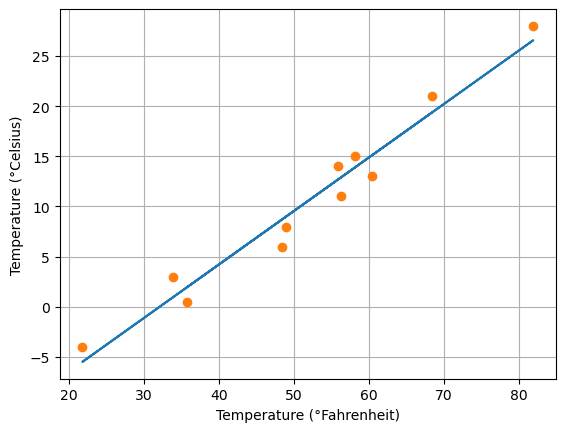

In [38]:
t_p = model(t_un, *(results[[1,0]]))

plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")

plt.plot(t_u.numpy(), t_p.numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.grid()
plt.show()

In [39]:
print('100 degrees Fahrenheit makes', round(float(model(100*scaling_factor, *(results[[1,0]]))),1), 'degrees Celcius?')
print('0 degrees Fahrenheit makes', round(float(model(0, *(results[[1,0]]))),1), 'degrees Celcius?')

100 degrees Fahrenheit makes 36.2 degrees Celcius?
0 degrees Fahrenheit makes -17.1 degrees Celcius?
